In [7]:
# # Test your imports
# from qiskit import *
# from qiskit import QuantumCircuit
# import qiskit.circuit.library as circuit_library
# import qiskit.quantum_info as qi
# from qiskit.utils import algorithm_globals
# from qiskit.circuit.library import EfficientSU2
# from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
# from qiskit_machine_learning.connectors import TorchConnector
import torch
# from qiskit.circuit import ParameterVector
from torch import Tensor
import torch.nn as nn
import numpy as np
# from qiskit.quantum_info import SparsePauliOp
from tqdm import tqdm
# from tensorflow.keras.preprocessing.sequence import pad_sequences

print("All imports successful!")

All imports successful!


In [9]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [10]:
# path='/content/gdrive/MyDrive/NLP_projects/Lucas'

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV file
df_2= pd.read_csv('final_dataset_pubmed.csv')

# Check the first few rows
df_2.head()

,NODE,Label,rat,common,use,examin,pathogenesi,retinopathi,mous,studi,...,kidney,urinari,myocardi,meal,ica,locus,tcell,depress,bone,mutat
0,12187484,1,46.967448,14.349229,5.880063,9.687707,31.58066,85.445293,33.85124,8.777305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2344352,1,11.808958,0.000000,7.392080,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14654069,1,51.131572,0.000000,5.334490,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16443886,2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2684155,1,15.307909,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Create a dictionary mapping column names to indices (excluding 'node' and 'label')
column_dict = {col: idx + 1 for idx, col in enumerate(df_2.columns) if col not in ['NODE', 'Label']}

# # View the dictionary
# print(column_dict)


In [13]:

# Assume df is your TF-IDF dataframe
df = df_2.reset_index(drop=True)
vocab = df.columns[2:]  # Skipping 'NODE' and 'Label' columns

def tfidf_to_review(row, max_words=300):
    word_list = []
    for word in vocab:
        tfidf_score = row[word]
        if tfidf_score > 0:
            repeat_count = int(tfidf_score // 5)  # Scale down to reduce long reviews
            word_list.extend([word] * repeat_count)
    return ' '.join(word_list[:max_words])  # Truncate to max_words

# Apply to all rows
pseudo_reviews = df.apply(tfidf_to_review, axis=1)

# Extract labels
labels = df['Label'].values


In [14]:
# # View pseudo-reviews with their corresponding class labels
# for i in range(5):
#     print(f"Label: {labels[i]} | Review: {pseudo_reviews[i]}")
#     print("-" * 100)



In [15]:
df = pd.DataFrame({'Label': labels, 'Pseudo_Review': pseudo_reviews})
print(df.head())


   Label                                      Pseudo_Review
0      1  rat rat rat rat rat rat rat rat rat common com...
1      1  rat rat use anim anim anim metabol metabol met...
2      1  rat rat rat rat rat rat rat rat rat rat use an...
3      2  model model model develop month month method l...
4      1  rat rat rat anim anim anim anim anim anim anim...


In [16]:
df=df[df['Label'].isin([1, 2])]
df.head()

,Label,Pseudo_Review
0,1,rat rat rat rat rat rat rat rat rat common com...
1,1,rat rat use anim anim anim metabol metabol met...
2,1,rat rat rat rat rat rat rat rat rat rat use an...
3,2,model model model develop month month method l...
4,1,rat rat rat anim anim anim anim anim anim anim...


In [17]:
# df= df.fillna(0).round().astype('Int64', errors='ignore')  # Fill NaNs with 0, round, and convert to integers


In [18]:
# df.head()

In [19]:
# Check for missing values
print(df.isnull().sum())
print(df.isnull().values.any())  # Returns True if any NaN is present


Label            0
Pseudo_Review    0
dtype: int64
False


In [20]:
import pandas as pd

# Suppose your DataFrame is called df
label_counts = df['Label'].value_counts()

print(label_counts)

Label
2    7875
1    4103
Name: count, dtype: int64


In [21]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['Label'] == 2]
df_minority = df[df['Label'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority), # match minority count
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Ensure the labels are integers before mapping
df_balanced['Label'] = df_balanced['Label'].astype(int).map({1: 0, 2: 1})


print(df_balanced['Label'].value_counts())

Label
1    4103
0    4103
Name: count, dtype: int64


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming your data looks like this:
# df = pd.DataFrame({'Pseudo_Review': [...], 'Label': [...]})
# You can load it or define it as needed.

# Example setup:
texts = df['Pseudo_Review'].astype(str).tolist()  # list of reviews
labels = df['Label'].astype(int).tolist()         # list of labels


2025-05-03 19:25:40.124365: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 19:25:40.185321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-03 19:25:42.421576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)


In [24]:
maxlen = 200  # choose based on average sequence length or experiment
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')


In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [26]:
df = df_balanced
print(df['Label'].value_counts())

Label
1    4103
0    4103
Name: count, dtype: int64


In [27]:
# Separate features and target
X = df.drop(columns=['Label'])  # Assuming 'Label' is the target
y = df['Label']

print(X.head())
print(y.head())


                                       Pseudo_Review
0  examin metabol lipid lipid lipid lipid lipid l...
1  metabol metabol metabol metabol metabol metabo...
2  compar method result 3 similar similar observ ...
3  use studi develop develop 2 compar 6 6 3 3 p p...
4  rat rat rat rat rat rat rat rat studi studi st...
0    1
1    1
2    1
3    1
4    0
Name: Label, dtype: int64


In [28]:
# Check the shapes of the splits
print(f'X_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (9582, 200), y_train shape: (9582,)
X_test shape: (2396, 200), y_test shape: (2396,)


In [29]:
print(x_train[0])


[ 90 140 216 216  85  85  28  43  78 130 130 219 219 219  11  11  55  55
  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55 189 189
 221 221 375 375 375  20  57  57  57  45 429 429 429  54 381 381 381 358
 358 358 129 129 129 129  98  98  98  98  98  98  98  98  98  98  98  98
  98  88 295 295 295  49 386 386 386 160 160 160 146 146 146 146 146 146
 146 229 229 229 242 242 242 176 176 176 176 176 236 236 236 236 315 315
 315 315  40  40  93  93  93  93 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 197 197 197 197 197
 197 197 197 197 197 197 197 197 197 197 197 197 197 197  23  23  23  23
  23  23  23  23  23  23  23  23  23  23 104 104 104  50  50  50  50  73
  73  73  73  73  73  73  73  73  73  73  73  73  73  73  73  73  73  73
 316 316]


In [30]:
# # # Handle missing values (e.g., fill with the mean of each column)
# # X = X.fillna(X.mean())

# # Split the data into training and testing sets (80% train, 20% test)
# x_train, x_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# # Check the shapes of the splits
# print(f'X_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
# print(f'X_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

In [31]:
print(type(y_train))

<class 'numpy.ndarray'>


In [32]:
y_train[0]

2

In [33]:
print(type(y_test))

<class 'numpy.ndarray'>


In [34]:
print("Unique y_train labels:", set(y_train))
print("Unique y_test labels:", set(y_test))


Unique y_train labels: {1, 2}
Unique y_test labels: {1, 2}


In [35]:
import random

selected_num = 128

# Remap labels before any sampling
y_train = [0 if y == 1 else 1 for y in y_train]
y_test = [0 if y == 1 else 1 for y in y_test]

# Now shuffle
train_data = list(zip(x_train, y_train))
test_data = list(zip(x_test, y_test))
...

# Shuffle data
train_data = list(zip(x_train, y_train))
test_data = list(zip(x_test, y_test))
random.shuffle(train_data)
random.shuffle(test_data)
x_train_shuffled, y_train_shuffled = zip(*train_data)
x_test_shuffled, y_test_shuffled = zip(*test_data)

# Balanced sampling for train
new_x_train = []
new_y_train = []
class_0_count = 0
class_1_count = 0
indx = 0

while len(new_x_train) < selected_num and indx < len(x_train_shuffled):
    label = y_train_shuffled[indx]
    if label == 0 and class_0_count < selected_num // 2:
        new_x_train.append(x_train_shuffled[indx])
        new_y_train.append(label)
        class_0_count += 1
    elif label == 1 and class_1_count < selected_num // 2:
        new_x_train.append(x_train_shuffled[indx])
        new_y_train.append(label)
        class_1_count += 1
    indx += 1

# Balanced sampling for test
new_x_test = []
new_y_test = []
class_0_count = 0
class_1_count = 0
indx = 0

while len(new_x_test) < selected_num and indx < len(x_test_shuffled):
    label = y_test_shuffled[indx]
    if label == 0 and class_0_count < selected_num // 2:
        new_x_test.append(x_test_shuffled[indx])
        new_y_test.append(label)
        class_0_count += 1
    elif label == 1 and class_1_count < selected_num // 2:
        new_x_test.append(x_test_shuffled[indx])
        new_y_test.append(label)
        class_1_count += 1
    indx += 1

# Check results
print("Train class balance:", new_y_train.count(0), new_y_train.count(1))
print("Test class balance:", new_y_test.count(0), new_y_test.count(1))


Train class balance: 64 64
Test class balance: 64 64


In [36]:
print("Train class balance:", new_y_train.count(0), new_y_train.count(1))
print("Test class balance:", new_y_test.count(0), new_y_test.count(1))


Train class balance: 64 64
Test class balance: 64 64


In [37]:
# print([len(str(x)) for x in new_x_train])  # Converts to string to avoid errors


In [38]:
x_train=np.array(new_x_train)#[:128]
y_train=np.array(new_y_train)#[:128]

x_test=np.array(new_x_test)#[:128]
y_test=np.array(new_y_test)#[:128]

print("x_train length:", len(x_train))
print("x_test length:", len(x_test))


x_train length: 128
x_test length: 128


In [39]:
import numpy as np

# STEP 1: Create column_dict with special tokens
# If you already have a dictionary like {'the': 1, 'and': 2, ...}, load or define it here.
# Example:
# column_dict = {'the': 1, 'and': 2, 'a': 3, 'of': 4, 'to': 5, ...}

# Shift existing indices to make room for special tokens
column_dict = {k: v + 4 for k, v in column_dict.items()}  
class_names = ["Diabetes Mellitus, Experimental", "Diabetes Mellitus Type 1", "Diabetes Mellitus Type 2"]

# Add special tokens
column_dict["<PAD>"] = 0
column_dict["<START>"] = 1
column_dict["<UNKNOWN>"] = 2
column_dict["<UNUSED>"] = 3

# Create reverse lookup dictionary
reverse_column_dict = {v: k for k, v in column_dict.items()}

# Function to decode list of token indices to human-readable text
def decode_review(encoded_text):
    return ' '.join([reverse_column_dict.get(i, "<UNKNOWN>") for i in encoded_text])

# STEP 2: Analyze review lengths
# Combine train and test reviews
allreviews = np.concatenate((x_train, x_test), axis=0)

# Print review length statistics
print("Maximum review length: {}".format(len(max(allreviews, key=len))))
print("Minimum review length: {}".format(len(min(allreviews, key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {:.2f}".format(np.mean(result)))

# STEP 3: Print machine-readable and human-readable versions of reviews
# Change index (e.g., 0 or 60) to inspect different examples
index = 0

print("\nMachine Readable Review")
print("  Text: " + str(x_train[index]))
print("  Type: " + str(y_train[index]))

print("\nHuman Readable Review")
print("  Text: " + decode_review(x_train[index]))
print("  Type: " + class_names[y_train[index]])



Maximum review length: 200
Minimum review length: 200
Mean review length: 200.00

Machine Readable Review
  Review Text: [ 19  19  71  71 177 177   4   4   4   4   4   4   4   4   4   4   4   4
   4   4 110 140  33  85  85 159 159 203 203 113 113 113 113 113 113 113
 113 113 189 189 259 259 259 259 259 259 299 299 299 299 299 299 299 299
 299 375 375 375 375 375 375 375 461 461 461 461 461 461 461 435 435 435
 435 435 435 435 435 354 354 354  10  10  57  57  57 429 429 429 137 137
 137   3   3   3   3 245 245 136 136 275 275 275 275 227 227 227 227 227
 181 181 181 246 246 246 246 398 398 398 398  53  53 325 325 325  84  84
  84  84  84  84  84  84  84  84  84  84  84  84  84  84 273 273 273  18
  18  18  18  18  18  18 255 255 255  23  23  23 156 156 156 156 156 156
 156 156 156 156  50  50  50  50  63  63  63  63  63  63  63  63  63  63
  63  63  63  63  63  63  63  63  63  63  63  63  63   7   7   7   7   7
   7   7]
  Review Sentiment: 1

Human Readable Review
  Review Text: contri

In [40]:

# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Text: " + str(x_train[60]))
print("  Type: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Text: " + decode_review(x_train[0]))
print("  Type: " + class_names[y_train[0]])


Maximum review length: 200
Minimum review length: 200
Mean review length: 200.0

Machine readable Review
  Review Text: [ 90 278 278 278 239 239 239  31  31  31  31  31  31  31   4   4   4   4
   4   4   4   4   4   4   4 114  56  56  56  56  56  56  30  33  33 458
 353 353 353 125 125  85  85 376 376 376 376  24  43  69  78 130 130 294
 294 294 134 134 134 134 134 469 469 469 469  20 204 204 204  57  57  57
  45  45  92  92  92  92   3   3   3   3  54  14  14  14  14  14  15  15
 223 223 223  32  32  32 102 102 102 240 240 240 136 136 160 160 160 227
 227 249 249 249 246 246 246 246  52  52  52  52  52  52 327 327 327 327
  16  16  16 149 149 149  84  84  84  84 438 438 438 438 438 438 438 438
 220 220 220 220 220 220 220 220 220 100 100 100 100 100 208 208 208 208
   7   7   7   7   7   7   7   7   7   7   7   7   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
  Review Sentiment: 1

Human Readable Review
  Review Text: contrib

In [41]:

new_X_train=[]
for seq in x_train:
    a=torch.tensor(np.pi*(seq/1000-0.5))
    new_X_train.append(torch.reshape(a, (10, 20)))

new_y_train=[]
for seq in y_train:
    new_y_train.append(torch.tensor(seq))

In [42]:

new_X_train=torch.stack(new_X_train)

label=torch.stack(new_y_train)

In [43]:

new_X_test=[]
for seq in x_test:
    a=torch.tensor(np.pi*(seq/1000-0.5))
    new_X_test.append(torch.reshape(a, (10, 20)))

new_y_test=[]
for seq in y_test:
    new_y_test.append(torch.tensor(seq))

In [46]:
import torch
import numpy as np
import random
import qiskit
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# If using a GPU, ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 42


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassicalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(ClassicalSelfAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, embed_dim)
        attn_output, _ = self.multihead_attn(x, x, x)
        x = self.layer_norm(x + attn_output)
        return x

class ClassicalSelfAttentionNetwork(nn.Module):
    def __init__(self, S, n, Denc, D, num_layers, num_heads=2):
        """
        S: number of sequences
        n: number of features per sequence (similar to number of qubits)
        Denc, D: encoding & variational depths (not used in classical directly)
        num_layers: number of attention layers
        num_heads: number of attention heads
        """
        super(ClassicalSelfAttentionNetwork, self).__init__()
        self.seq_len = S
        self.embed_dim = n * (Denc + 2)

        # Define a stack of classical self-attention layers
        self.attention_layers = nn.ModuleList([
            ClassicalSelfAttention(self.embed_dim, num_heads) for _ in range(num_layers)
        ])

        # Final classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.embed_dim * self.seq_len, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, embed_dim)
        for attn_layer in self.attention_layers:
            x = attn_layer(x)

        x = torch.flatten(x, start_dim=1)  # Flatten all features
        out = torch.sigmoid(self.classifier(x))
        return out


In [50]:
model = ClassicalSelfAttentionNetwork(S=10, n=2, Denc=8, D=1, num_layers=1, num_heads=1)


In [54]:
criterion = torch.nn.CrossEntropyLoss()

In [55]:
optimizer = torch.optim.Adam(lr=0.005, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [56]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

8185


In [57]:
new_X_train.shape[0]  # Number of training samples

128

In [58]:
import torch
import os

In [59]:
# Make sure everything is tensor first
if isinstance(new_X_train, list):
    new_X_train = torch.stack(new_X_train)

if isinstance(new_y_train, list):
    new_y_train = torch.stack(new_y_train)

if isinstance(new_X_test, list):
    new_X_val = torch.stack(new_X_test)
else:
    new_X_val = new_X_test

if isinstance(new_y_test, list):
    new_y_val = torch.stack(new_y_test)
else:
    new_y_val = new_y_test


In [60]:
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare data
# new_X_train = torch.stack(new_X_train)
# label = torch.stack(new_y_train)

new_X_val = torch.stack(new_X_test)   # Use your test set as validation set
new_y_val = torch.stack(new_y_test)


# Dataloaders
batch_size = 32

train_dataset = TensorDataset(new_X_train, label)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(new_X_val, new_y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss, Optimizer, Scheduler
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

# Training loop
n_epochs = 100
patience = 10
best_val_acc = 0
epochs_no_improve = 0

def binary_accuracy(preds, y):
    # For BCELoss outputs
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch.float()).squeeze(1)
        loss = criterion(predictions, y_batch.float())

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += binary_accuracy(predictions, y_batch)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Validation
    model.eval()
    val_acc = 0
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            preds = model(X_val.float()).squeeze(1)
            loss = criterion(preds, y_val.float())
            val_loss += loss.item()
            val_acc += binary_accuracy(preds, y_val)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_CSANN.pt')  # save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"Total training time: {total_time/60:.2f} minutes")


Epoch 1: Train Loss=0.7036, Train Acc=0.5234, Val Loss=0.6882, Val Acc=0.5078
Epoch 2: Train Loss=0.6939, Train Acc=0.5469, Val Loss=0.6750, Val Acc=0.5547
Epoch 3: Train Loss=0.6328, Train Acc=0.6328, Val Loss=0.6701, Val Acc=0.5938
Epoch 4: Train Loss=0.5807, Train Acc=0.7344, Val Loss=0.6475, Val Acc=0.6250
Epoch 5: Train Loss=0.5258, Train Acc=0.7734, Val Loss=0.6409, Val Acc=0.6172
Epoch 6: Train Loss=0.4844, Train Acc=0.8125, Val Loss=0.6523, Val Acc=0.6562
Epoch 7: Train Loss=0.4199, Train Acc=0.8203, Val Loss=0.6536, Val Acc=0.6172
Epoch 8: Train Loss=0.3696, Train Acc=0.8594, Val Loss=0.6473, Val Acc=0.6562
Epoch 9: Train Loss=0.3251, Train Acc=0.8750, Val Loss=0.6593, Val Acc=0.6641
Epoch 10: Train Loss=0.2921, Train Acc=0.8906, Val Loss=0.6954, Val Acc=0.6484
Epoch 11: Train Loss=0.2246, Train Acc=0.9297, Val Loss=0.7420, Val Acc=0.6328
Epoch 12: Train Loss=0.1926, Train Acc=0.9688, Val Loss=0.8174, Val Acc=0.6250
Epoch 13: Train Loss=0.1569, Train Acc=0.9688, Val Loss=0.824

In [61]:
path ='take_2'

In [62]:

file_name=path+'m_csann'
torch.save(model.state_dict(),file_name)

In [72]:

# 1. Create model instance first
model = ClassicalSelfAttentionNetwork(S=10, n=2, Denc=8, D=1, num_layers=1, num_heads=1)


# 2. Load weights
model.load_state_dict(torch.load('best_model_CSANN.pt'))

# 3. Move to device (cuda or cpu)
model = model.to(device)

# 4. Set to evaluation mode
model.eval()


ClassicalSelfAttentionNetwork(
  (attention_layers): ModuleList(
    (0): ClassicalSelfAttention(
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
      )
      (layer_norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [74]:
# new_X_test = torch.stack(new_X_test)  # Shape: (num_samples, 10, 20)
# new_y_test = torch.tensor(new_y_test)  # Automatically stacks scalar tensors


# Check shapes
print("Train input shape:", new_X_train.shape)
print("Test input shape:", new_X_test.shape)

# Check data types
print("Train input dtype:", new_X_train.dtype)
print("Test input dtype:", new_X_test.dtype)

# Check devices
print("Train input device:", new_X_train.device)
print("Test input device:", new_X_test.device)

# Check value ranges (optional but helpful)
print("Train input min/max:", new_X_train.min().item(), new_X_train.max().item())
print("Test input min/max:", new_X_test.min().item(), new_X_test.max().item())

Train input shape: torch.Size([128, 10, 20])
Test input shape: torch.Size([128, 10, 20])
Train input dtype: torch.float64
Test input dtype: torch.float64
Train input device: cpu
Test input device: cpu
Train input min/max: -1.5707963267948966 -0.006283185307179592
Test input min/max: -1.5707963267948966 -0.006283185307179592


In [75]:
# new_X_test = torch.stack(new_X_test)  # Shape: (num_samples, 10, 20)
# new_y_test = torch.tensor(new_y_test)  # Automatically stacks scalar tensors


In [76]:
# Check shapes
print("Train input shape:", new_X_train.shape)
print("Test input shape:", new_X_test.shape)

# Check data types
print("Train input dtype:", new_X_train.dtype)
print("Test input dtype:", new_X_test.dtype)

# Check devices
print("Train input device:", new_X_train.device)
print("Test input device:", new_X_test.device)

# Check value ranges (optional but helpful)
print("Train input min/max:", new_X_train.min().item(), new_X_train.max().item())
print("Test input min/max:", new_X_test.min().item(), new_X_test.max().item())


Train input shape: torch.Size([128, 10, 20])
Test input shape: torch.Size([128, 10, 20])
Train input dtype: torch.float64
Test input dtype: torch.float64
Train input device: cpu
Test input device: cpu
Train input min/max: -1.5707963267948966 -0.006283185307179592
Test input min/max: -1.5707963267948966 -0.006283185307179592


In [77]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure test data is properly stacked
if isinstance(new_X_test, list):
    new_X_test = torch.stack(new_X_test)
if isinstance(new_y_test, list):
    new_y_test = torch.stack(new_y_test)

# Create the DataLoader
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(new_X_test, new_y_test),
    batch_size=32,
    shuffle=False
)

# Define the test accuracy function
def test_accuracy(model, test_loader, device):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(1)
            preds = torch.round(outputs)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

accuracies = []

# Loop to reload model and test each time
for run in range(1):
    # Re-load the model

    # Test the model
    acc = test_accuracy(model, test_loader, device)
    accuracies.append(acc)
    print(f"Run {run+1}: Test Accuracy = {acc:.4f}")

# Final statistics
print(f"\nAverage Test Accuracy over 100 runs: {sum(accuracies)/len(accuracies):.4f}")
print(f"Max Accuracy: {max(accuracies):.4f}, Min Accuracy: {min(accuracies):.4f}")


Run 1: Test Accuracy = 0.6641

Average Test Accuracy over 100 runs: 0.6641
Max Accuracy: 0.6641, Min Accuracy: 0.6641


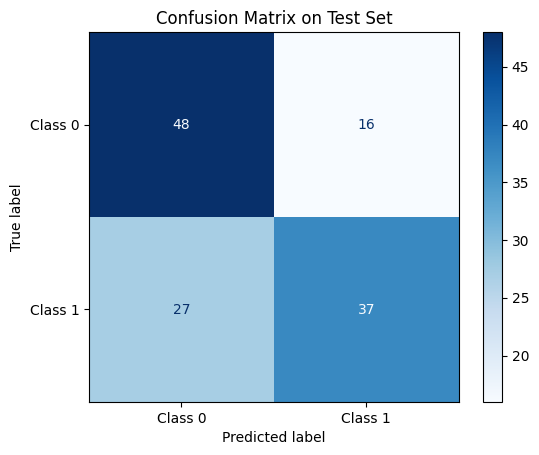

In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# 2. Prepare the test DataLoader
if isinstance(new_X_test, list):
    new_X_test = torch.stack(new_X_test)
if isinstance(new_y_test, list):
    new_y_test = torch.stack(new_y_test)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(new_X_test, new_y_test),
    batch_size=32,
    shuffle=False
)

# 3. Gather all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()

        outputs = model(inputs).squeeze(1)
        preds = torch.round(outputs)  # Binary thresholding at 0.5

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# 4. Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# 5. Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 6. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()


              precision    recall  f1-score   support

     Class 0       0.64      0.75      0.69        64
     Class 1       0.70      0.58      0.63        64

    accuracy                           0.66       128
   macro avg       0.67      0.66      0.66       128
weighted avg       0.67      0.66      0.66       128

Confusion Matrix:
 [[48 16]
 [27 37]]


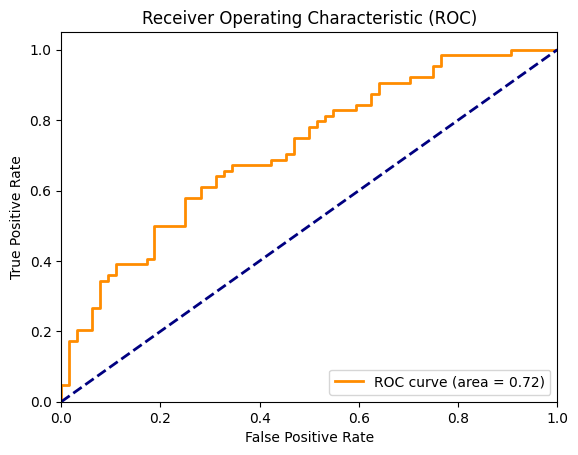

In [79]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import torch



all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze(1)
        preds = torch.round(outputs)
        
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Classification Report (Precision, Recall, F1)
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# ROC Curve
# Need probabilities, not rounded predictions
probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        outputs = model(inputs).squeeze(1)
        probs.append(outputs.cpu())

probs = torch.cat(probs)

fpr, tpr, thresholds = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
